In [2]:
NAME_STUDENT_1 = "Tianze Wang"
NAME_STUDENT_2 = "Egor Lomagin"

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import openml as oml
%matplotlib inline

In [192]:
sb.set_style('white')

## Support Vector Bananas (4 points (2+2))
We will first explore SVM kernels and hyperparameters on an artificial dataset representing multiple banana shapes. 

In [8]:
from sklearn.model_selection import train_test_split

In [25]:
bananas = oml.datasets.get_dataset(1460) # Download banana data
X, y = bananas.get_data(target=bananas.default_target_attribute);
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/4)

In [42]:
_, ax = plt.subplots(1, 3, sharex=True, figsize=(18, 6))
plt.figure(figsize=(18, 6))
ax[0].scatter(X[y == 0, 0], X[y == 0, 1])
ax[1].scatter(X[y == 1, 0], X[y == 1, 1])
ax[2].scatter(X[:, 0], X[:, 1], c=y)

1 . Evaluate how well an SVM classifier can fit the data. 

- Use a linear, polynomial and radial basis function (RBF) kernel, using their default hyperparameters. Evaluate the performance of each kernel using the test set and AUC. Which one works best? 
- Visualize the results using the visualization code also used in class (under mglearn/plot_svm.py > plot_svm_kernels). Also show the AUC score and the number of support vectors. Explain intuitively how well the data is fitted, why the kernel is (not) able to fit the data, whether it is under- or overfitting, etc.

In [13]:
from sklearn import svm

In [178]:
def plot_svm_model(clf, X, Y, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.set_title('kernel = {}, C = {}, $\gamma$ = {}'.format(clf.kernel, clf.C, clf.gamma))
    ax.scatter(X[:, 0], X[:, 1], c=Y, alpha=0.2, zorder=10, cmap=plt.cm.bwr)
    ax.axis('tight')
    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    ax.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.bwr, alpha=0.1)
    ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.set_xticks(())
    ax.set_yticks(())

In [145]:
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

#### **SVM with linear kernel**

In [146]:
linear_svm = SVC(kernel='linear')

In [147]:
linear_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [148]:
roc_auc_score(y_test, linear_svm.predict(X_test))

0.5

In [163]:
len(linear_svm.support_vectors_)

3613

#### **SVM with polynomial kernel**

In [149]:
poly_svm = SVC(kernel='poly')

In [150]:
poly_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [151]:
roc_auc_score(y_test, poly_svm.predict(X_test))

0.6058620689655173

In [165]:
len(poly_svm.support_vectors_)

3218

#### **SVM with rbf kernel**

In [152]:
rbf_svm = SVC(kernel='rbf')

In [153]:
rbf_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [154]:
roc_auc_score(y_test, rbf_svm.predict(X_test))

0.9095977011494253

In [166]:
len(rbf_svm.support_vectors_)

1180

#### **Decision boundaries**

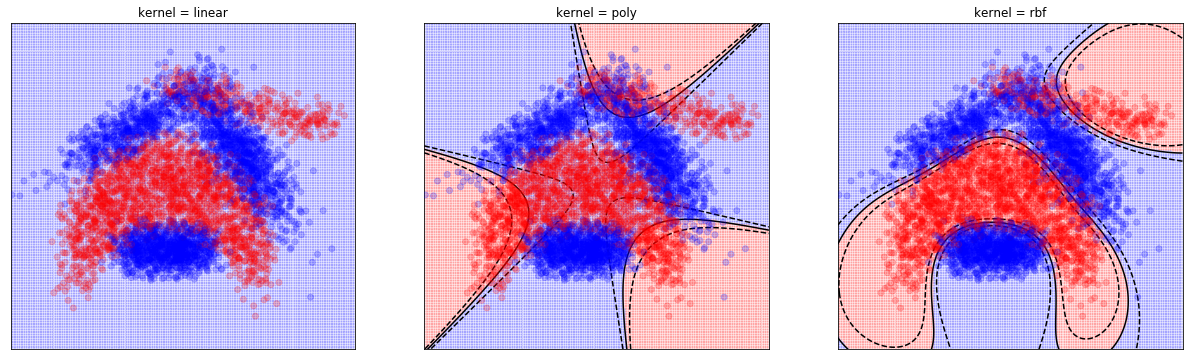

In [160]:
_, axes = plt.subplots(1, 3, figsize=(21, 6))
plot_svm_model(linear_svm, X, y, axes[0])
plot_svm_model(poly_svm, X, y, axes[1])
plot_svm_model(rbf_svm, X, y, axes[2])

# **TODO: write conclusion**

2 . Pick the RBF kernel and optimize the two most important hyperparameters (the $C$ parameter and the kernel width $\gamma$). 

- First, optimize manually using 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?
- Next, optimize the hyperparameters using a grid search and 10-fold cross validation. Show a heatmap of the results snd report the optimal hyperparameter values.
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. Use at least 10 values for each.

In [168]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

#### **Manual C and $\gamma$ tunning**

In [175]:
def svm_metrics(model, X, y):
    score = cross_val_score(model, X, y, scoring='roc_auc', cv=KFold(10, True))
    model.fit(X, y)
    return score.mean(), len(model.support_vectors_)

In [176]:
rbf_s_s = SVC(kernel='rbf', C=2**-12, gamma=2**-12)
rbf_s_d = SVC(kernel='rbf', C=2**-12)
rbf_s_l = SVC(kernel='rbf', C=2**-12, gamma=2**12)
rbf_d_s = SVC(kernel='rbf', gamma=2**-12)
rbf_d_d = SVC(kernel='rbf')
rbf_d_l = SVC(kernel='rbf', gamma=2**12)
rbf_l_s = SVC(kernel='rbf', C=2**12, gamma=2**-12)
rbf_l_d = SVC(kernel='rbf', C=2**12)
rbf_l_l = SVC(kernel='rbf', C=2**12, gamma=2**12)

In [177]:
print('SS ', svm_metrics(rbf_s_s, X, y))
print('SD ', svm_metrics(rbf_s_d, X, y))
print('SL ', svm_metrics(rbf_s_l, X, y))
print('DS ', svm_metrics(rbf_d_s, X, y))
print('DD ', svm_metrics(rbf_d_d, X, y))
print('DL ', svm_metrics(rbf_d_l, X, y))
print('LS ', svm_metrics(rbf_l_s, X, y))
print('LD ', svm_metrics(rbf_l_d, X, y))
print('LL ', svm_metrics(rbf_l_l, X, y))

SS  (0.5466032959563637, 4752)
SD  (0.8551273771995366, 4752)
SL  (0.8799401127649968, 4752)
DS  (0.6157085566090277, 4757)
DD  (0.9663447746674965, 1481)
DL  (0.8737267937378259, 5194)
LS  (0.5948217409875364, 4636)
LD  (0.96746915732249, 1158)
LL  (0.8714737871266024, 5169)


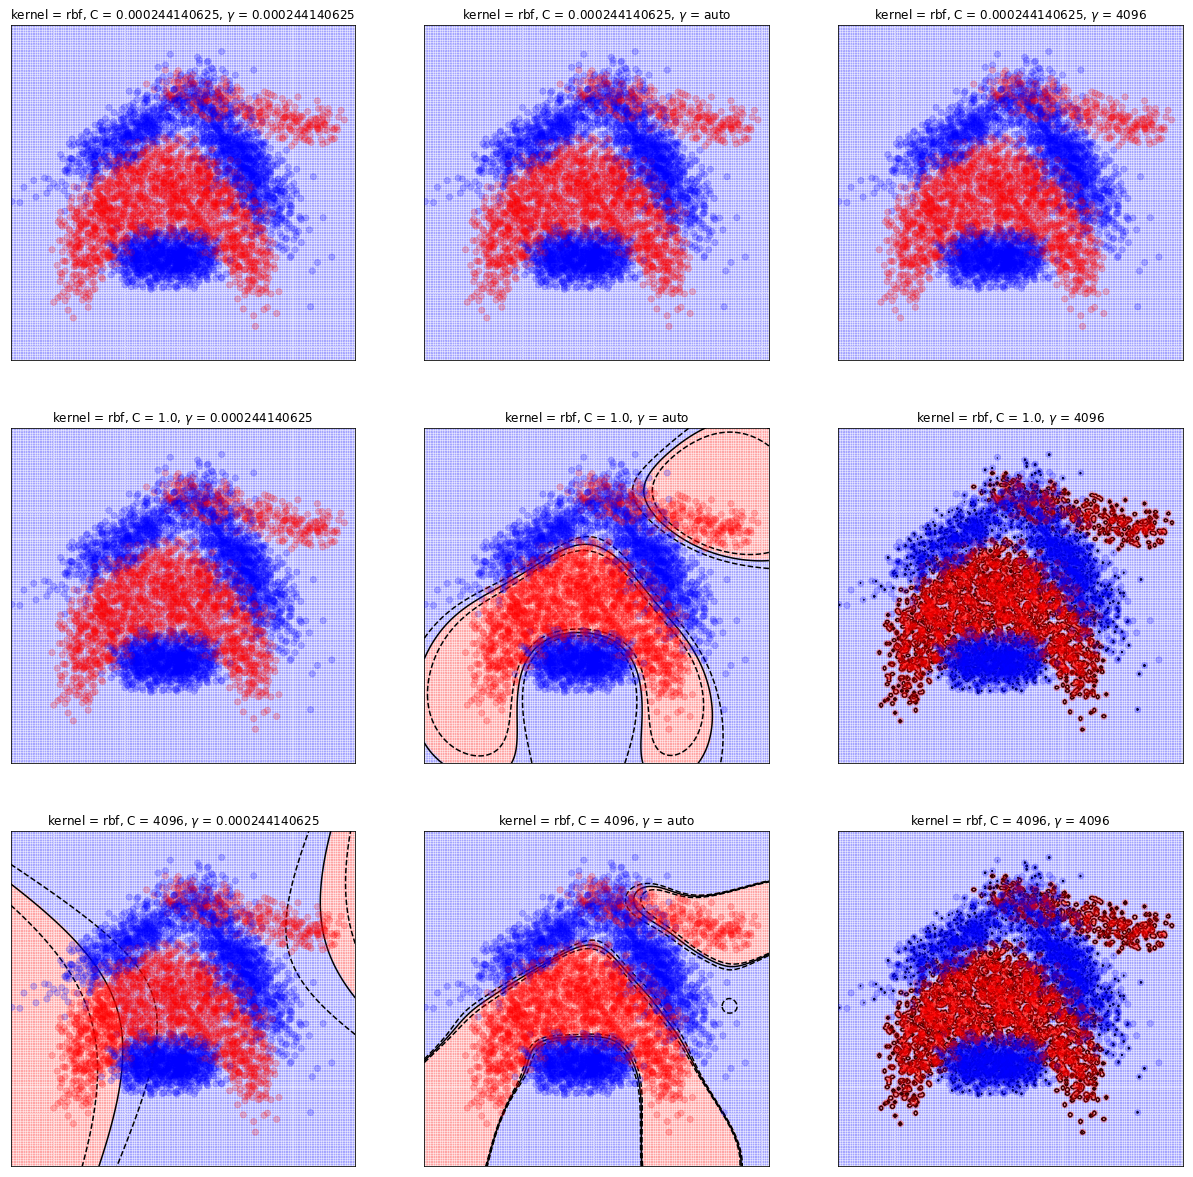

In [179]:
_, axes = plt.subplots(3, 3, figsize=(21, 21))
plot_svm_model(rbf_s_s, X, y, axes[0][0])
plot_svm_model(rbf_s_d, X, y, axes[0][1])
plot_svm_model(rbf_s_l, X, y, axes[0][2])
plot_svm_model(rbf_d_s, X, y, axes[1][0])
plot_svm_model(rbf_d_d, X, y, axes[1][1])
plot_svm_model(rbf_d_l, X, y, axes[1][2])
plot_svm_model(rbf_l_s, X, y, axes[2][0])
plot_svm_model(rbf_l_d, X, y, axes[2][1])
plot_svm_model(rbf_l_l, X, y, axes[2][2])

# **TODO: add conclusions**

#### **GridSearchCV C and $\gamma$ tunning**

In [183]:
params_svm_rbf = {
    'gamma': [2**x for x in range(-12, 12)],
    'C': [2**x for x in range(-12, 12)],
}

In [184]:
rbf_svm = SVC(kernel='rbf')

In [186]:
grid_cv = GridSearchCV(rbf_svm, params_svm_rbf, scoring='roc_auc', n_jobs=4, cv=KFold(10, True), verbose=10)

In [187]:
grid_cv.fit(X, y)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   30.8s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   40.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   44.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   55.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Do

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'gamma': [0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048], 'C': [0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [193]:
grid_df = pd.DataFrame()
grid_df['gamma'] = grid_cv.cv_results_['param_gamma'].data
grid_df['C'] = grid_cv.cv_results_['param_C'].data
grid_df['roc_auc'] = grid_cv.cv_results_['mean_test_score']

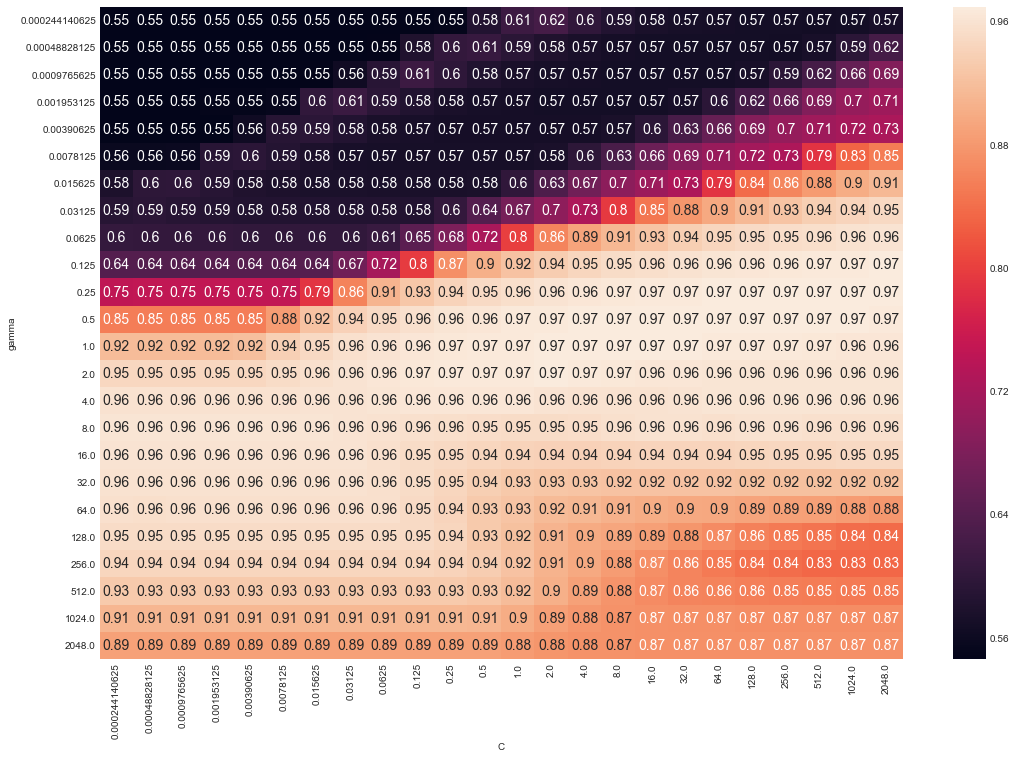

In [197]:
plt.figure(figsize=(18, 12))
sb.heatmap(grid_df.pivot('gamma', 'C', 'roc_auc'), xticklabels=True, yticklabels=True, annot=True, annot_kws={'size':14})